## Import libraries

In [20]:
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
import time
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd

In [21]:
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.layers import Reshape

In [22]:
import os
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
# from keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras
# from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
from keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import classification_report, confusion_matrix


## Read the test set

In [23]:
#generate images from train set and validation set
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128

test_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 1009 images belonging to 4 classes.


In [24]:
#generate labels indicating disease (1) or normal (0)
label=validation_generator.class_indices
label={v: k for k, v in label.items()}

In [25]:
print(label)

{0: '0', 1: '1', 2: '2', 3: '3'}


In [26]:
#read images from validation folder
rootdir = './test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[3],test_images[0])

0 ./test_224/0/29424.png


In [27]:
set(list(test_laels))

{'0', '1', '2', '3'}

## Load  trained models (CNN & LSTM)

In [28]:
#load model 3: Hybrid
hybrid_scratch_model=load_model('source_cnn_lstm_hybrid_final_model.h5')

# Hybrid model

In [29]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    lstm_model_batch=hybrid_scratch_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=lstm_model_batch[0,np.argmax(lstm_model_batch,axis=1)[0]]
    res=label[np.argmax(lstm_model_batch,axis=1)[0]]
    predict.append(res)

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step
CPU times: user 1min 22s, sys: 1.75 s, total: 1min 24s
Wall time: 1min


In [30]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('Hybrid source TF accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0','1','2','3']
print(classification_report(test_laels, predict, target_names=target_names))

Hybrid source TF accuracy: 0.9534192269573836
precision: 0.9092737112373511
recall: 0.9534192269573836
f1: 0.9307539964420728
[[852   0   0   0]
 [  0  57   0   0]
 [ 47   0   0   0]
 [  0   0   0  53]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       852
           1       1.00      1.00      1.00        57
           2       0.00      0.00      0.00        47
           3       1.00      1.00      1.00        53

    accuracy                           0.95      1009
   macro avg       0.74      0.75      0.74      1009
weighted avg       0.91      0.95      0.93      1009



Text(0.5, 1.0, 'Confusion matrix of Hybrid source TF model')

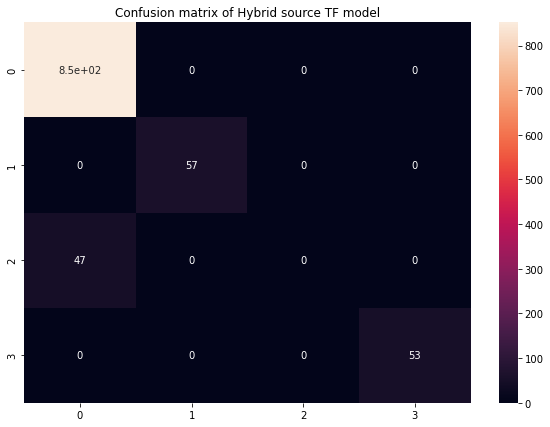

In [31]:
plt.figure(figsize=(10,7))
cf_matrix = confusion_matrix(test_laels, predict)
cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.3f')
ax.set_title("Confusion matrix of Hybrid source TF model")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")